In [12]:
%matplotlib inline
import numpy as np
from scipy.misc import imread
import pickle
import matplotlib.pyplot as plt
from scipy.misc import imread, imresize
import tensorflow as tf
from keras.preprocessing import image
from keras.backend.tensorflow_backend import set_session
from ssd import SSD300
from keras.applications.imagenet_utils import preprocess_input
from ssd_utils import BBoxUtility
import matplotlib.pyplot as plt
from SSD_tester import calc_detection_prec_rec, calc_detection_ap
from SSD_RGBD import RGBD_SSD300
from depth_preprocess import hole_filling
import cv2

config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
        visible_device_list="0",
        allow_growth=True 
    )
)
sess = sess = tf.Session(config=config)



In [13]:
NYU_CLASSES = ['bathtub', 'bed', 'bookshelf', 'box', 'chair', 'counter', 'desk', 'door', 'dresser',
               'garbage_bin', 'lamp', 'monitor', 'night_stand', 'pillow', 'sink', 'sofa', 'table', 'tv', 'toilet']
NUM_CLASSES = len(NYU_CLASSES) + 1
rgb_input_shape = (300, 300, 3) #channel lastde
depth_input_shape = (300, 300, 1)

In [14]:
model = RGBD_SSD300(rgb_input_shape, depth_input_shape, num_classes=NUM_CLASSES)
model.load_weights('/data/jun/checkpoints/SUNRGBD/estimation/RGBD-1/v1/weights-5.49-2.30.hdf5',by_name=True)

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,512,512]
	 [[Node: block4_conv2_2/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=4367610, _device="/job:localhost/replica:0/task:0/gpu:0"](block4_conv2_2/random_uniform/shape)]]

Caused by op 'block4_conv2_2/random_uniform/RandomUniform', defined at:
  File "/usr/lib/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.4/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-e6ed84f8580b>", line 1, in <module>
    model = RGBD_SSD300(rgb_input_shape, depth_input_shape, num_classes=NUM_CLASSES)
  File "/home/jun/projects/rgbd-SSD/src/SSD_RGBD.py", line 22, in RGBD_SSD300
    vgg16 = VGG16(weights='imagenet', include_top=False)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/keras/applications/vgg16.py", line 129, in VGG16
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/keras/engine/topology.py", line 575, in __call__
    self.build(input_shapes[0])
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/keras/layers/convolutional.py", line 134, in build
    constraint=self.kernel_constraint)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/keras/engine/topology.py", line 396, in add_weight
    weight = K.variable(initializer(shape),
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/keras/initializers.py", line 212, in __call__
    dtype=dtype, seed=self.seed)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/keras/backend/tensorflow_backend.py", line 3544, in random_uniform
    dtype=dtype, seed=seed)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/tensorflow/python/ops/random_ops.py", line 240, in random_uniform
    shape, dtype, seed=seed1, seed2=seed2)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/tensorflow/python/ops/gen_random_ops.py", line 247, in _random_uniform
    seed=seed, seed2=seed2, name=name)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/jun/.virtualenvs/rgbd-ssd/lib/python3.4/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[3,3,512,512]
	 [[Node: block4_conv2_2/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=4367610, _device="/job:localhost/replica:0/task:0/gpu:0"](block4_conv2_2/random_uniform/shape)]]


In [ ]:
rgb_gt = pickle.load(open('../pkls/SUNRGBD/RGB_v8.pkl', 'rb'))
depth_gt = pickle.load(open('../pkls/SUNRGBD/Depth_v8.pkl', 'rb'))
rgb_keys = pickle.load(open('/data/jun/pkls/RGBD-1/rgb-v1.pkl', 'rb'))
depth_keys = pickle.load(open('/data/jun/pkls/RGBD-1/depth-v1.pkl', 'rb'))
num_train = int(round(0.8 * len(rgb_keys)))
rgb_train_keys = rgb_keys[:num_train]
depth_train_keys = depth_keys[:num_train]
num_val = int(round((len(rgb_keys) - num_train)/2))
rgb_val_keys = rgb_keys[num_train:]
rgb_val_keys = rgb_val_keys[:num_val]
depth_val_keys = depth_keys[num_train:]
depth_val_keys = depth_val_keys[:num_val]
rgb_test_keys = rgb_keys[num_train:]
rgb_test_keys = rgb_test_keys[num_val:]
depth_test_keys = depth_keys[num_train:]
depth_test_keys = depth_test_keys[num_val:]
print(depth_keys[0])

In [ ]:
path_prefix = '/data/jun/dataset/'
rgb_inputs = []
depth_inputs = []
images = []
# img_path = path_prefix + sorted(val_keys )[100]
# img = image.load_img(img_path, target_size=(300, 300))
# img = image.img_to_array(img)
# images.append(imread(img_path))
# inputs.append(img.copy())
# inputs = preprocess_input(np.array(inputs))

for rgb_key, depth_key in zip(rgb_test_keys, depth_test_keys):
    rgb_img_path = path_prefix + rgb_key
    depth_img_path = path_prefix + depth_key
    rgb_img = imread(rgb_img_path).astype('float32')
    depth_img = imread(depth_img_path, mode='L').astype('float32')
    rgb_img = imresize(rgb_img, (300, 300)).astype('float32')
    depth_img = imresize(depth_img, (300, 300)).astype('float32')
    depth_img = depth_img / np.max(depth_img)
    depth_img = np.sqrt(depth_img)
    depth_img = np.array(depth_img*256, dtype=int)
    depth_img = hole_filling(depth_img)
    depth_img = np.uint8(depth_img)
    depth_img = cv2.Canny(depth_img, 70, 110)
    depth_img = cv2.bilateralFilter(depth_img, d=5, sigmaColor=5, sigmaSpace=2)
    depth_img = np.expand_dims(depth_img, axis=2)
    std = np.std(rgb_img)
    rgb_img -= np.mean(rgb_img)
    rgb_img /= std
    img = imread(rgb_img_path)
    images.append(img)

    
    rgb_inputs.append(rgb_img.copy())
    depth_inputs.append(depth_img.copy())
    
inputs = [np.array(rgb_inputs), np.array(depth_inputs)]

In [ ]:
inputs[0].shape



In [ ]:
priors = pickle.load(open('../pkls/prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)
preds = model.predict(inputs, batch_size=16, verbose=1)

In [ ]:
results = bbox_util.detection_out(preds, confidence_threshold=0.5)

In [ ]:
gt_bboxes = []
gt_labels = []
gt_scores = []
for key in rgb_test_keys:
    index = np.where(rgb_gt[key][:, 4:] == 1)
    gt_bboxes.append(rgb_gt[key][:, :4])
    gt_labels.append((index[1]).reshape(len(index[1]), 1))
    gt_scores.append(np.ones((len(index[1]), 1)))
gt_bboxes = np.array(gt_bboxes)
gt_labels = np.array(gt_labels)
gt_scores = np.array(gt_scores)

In [ ]:
pred_labels = []
pred_scores = []
pred_bboxes = []
for result in results:
    if len(result) != 0:
        nm = len(result[:, 1])
        pred_labels.append((result[:, 0]-1).reshape(nm, 1))
        pred_scores.append(result[:, 1:2].reshape(nm, 1))
        pred_bboxes.append(result[:, 2:].reshape(nm, 4))
    else:
        pred_labels.append(np.array([]).reshape(0, 1))
        pred_scores.append(np.array([]).reshape(0, 1))
        pred_bboxes.append(np.array([]).reshape(0, 1))
pred_labels = np.array(pred_labels)
pred_scores = np.array(pred_scores)

pred_bboxes = np.array(pred_bboxes)

In [ ]:
gt_labels.shape

In [ ]:
prec, rec, mean_iou = calc_detection_prec_rec(pred_labels, pred_scores, pred_bboxes, gt_bboxes, gt_labels, iou_thresh=0.5)

In [ ]:
ap = calc_detection_ap(prec, rec, use_07_metric=True)
{'ap': ap, 'map': np.nanmean(ap)}

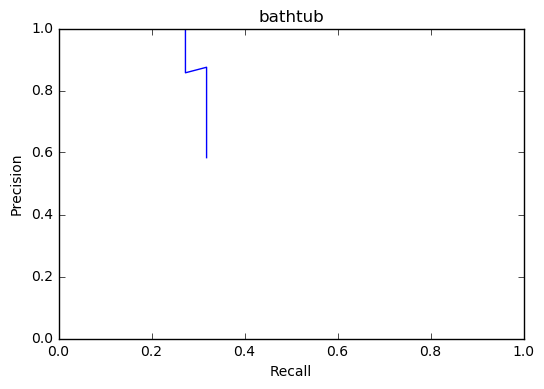

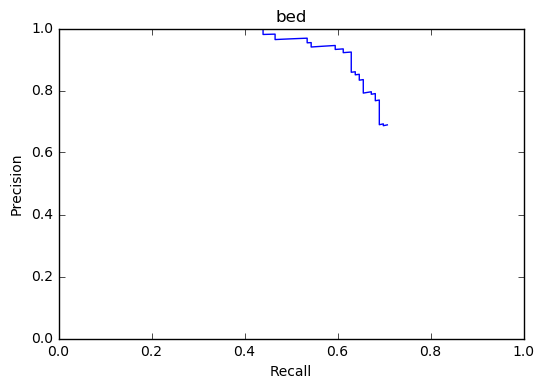

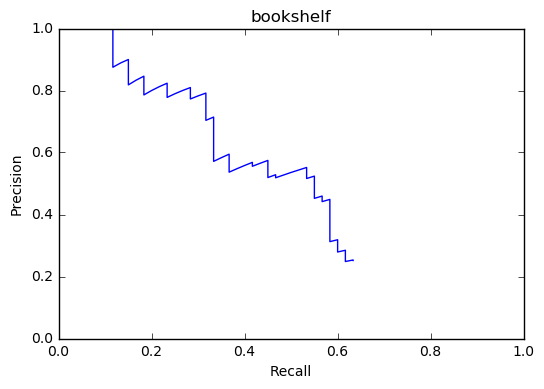

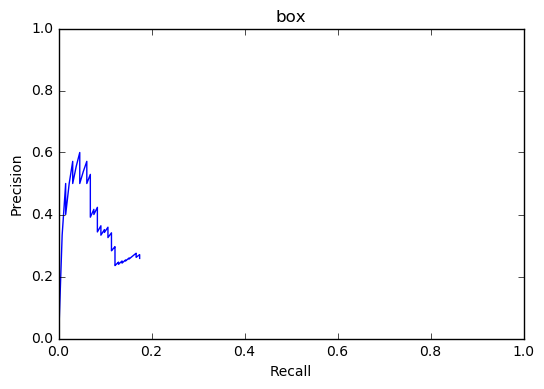

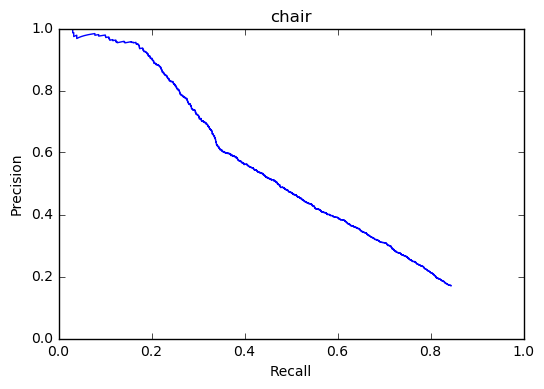

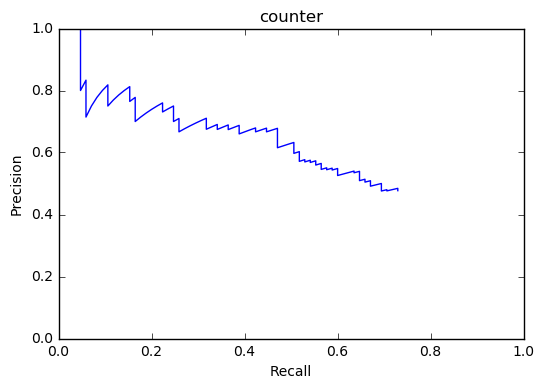

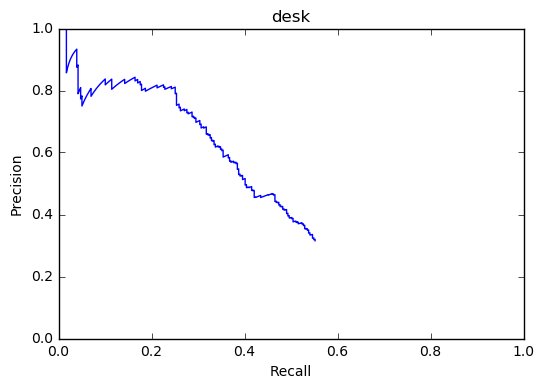

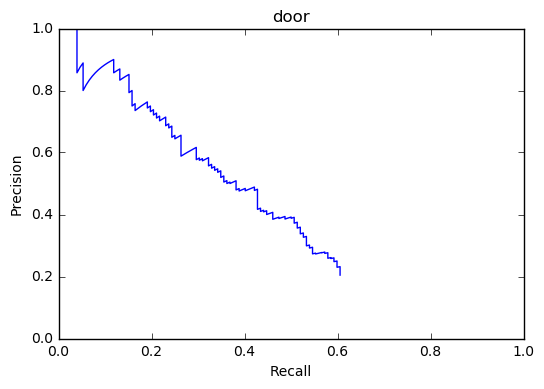

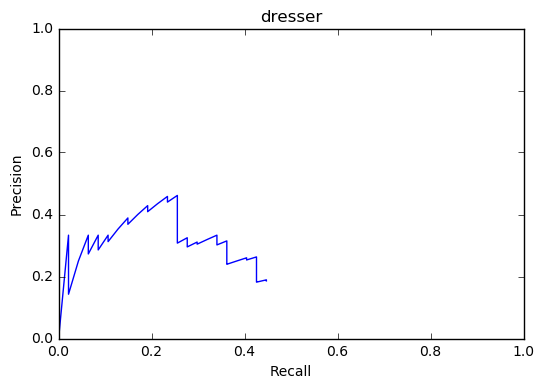

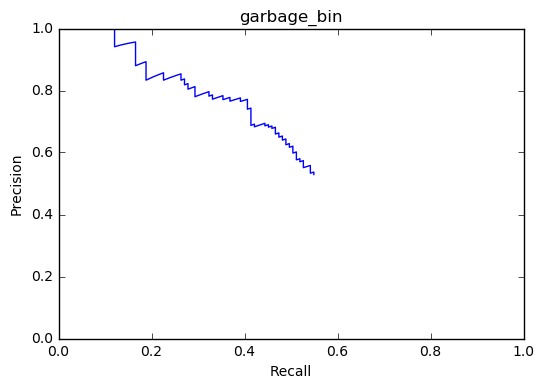

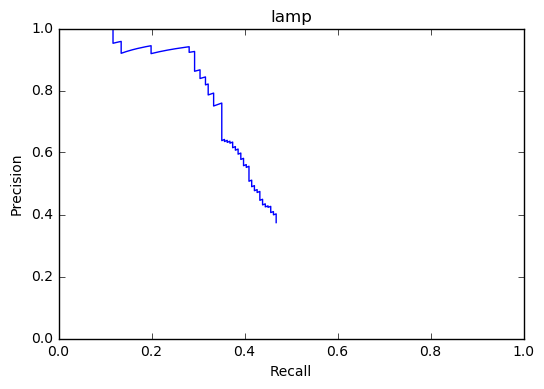

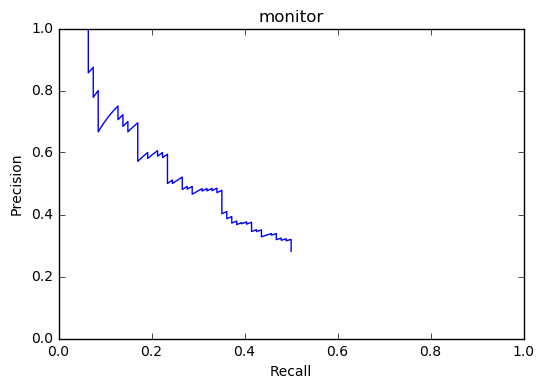

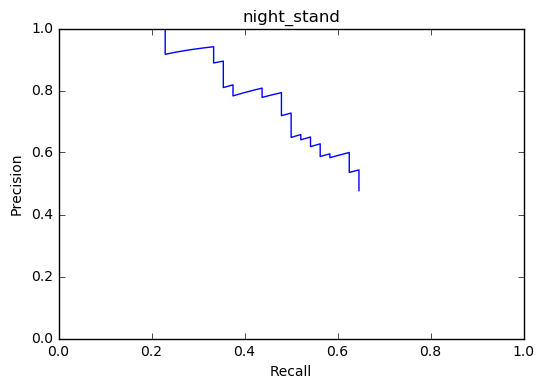

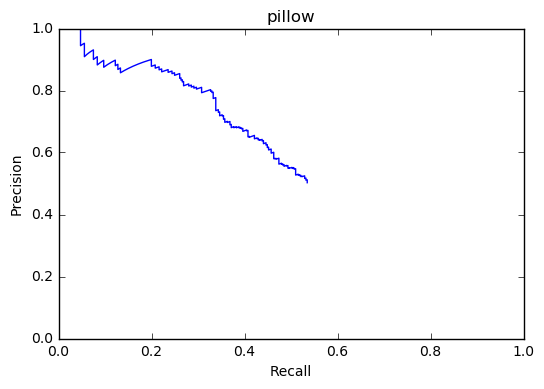

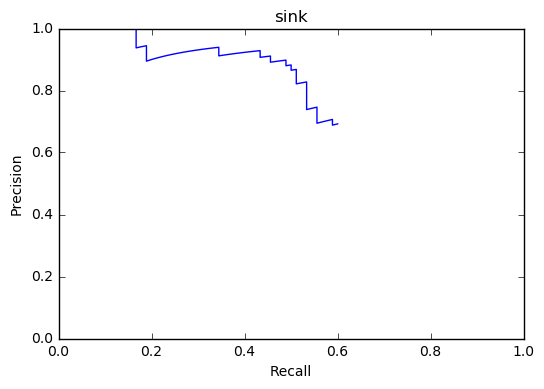

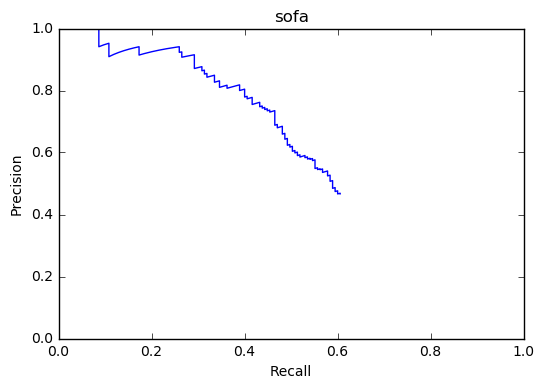

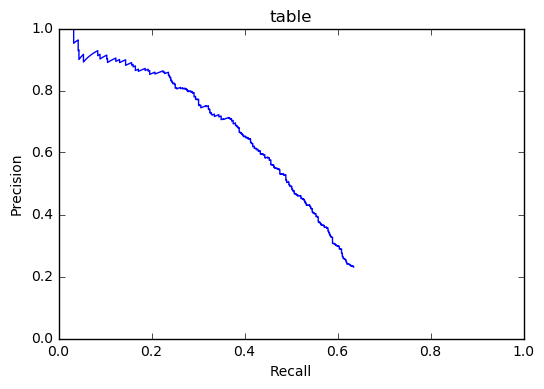

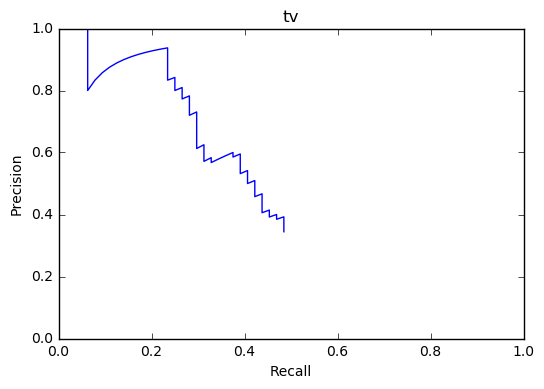

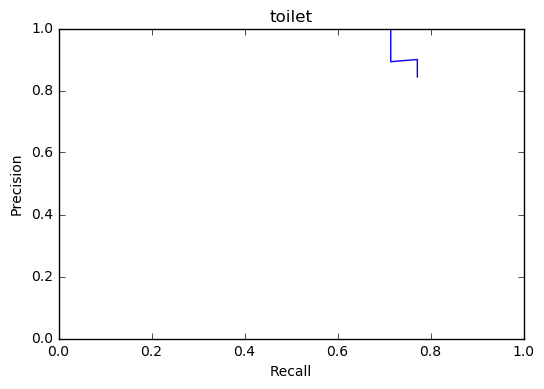

In [19]:
for i in range(len(NYU_CLASSES)):
    plt.figure()
    y = prec[i]
    x = rec[i]

    plt.plot(x, y)
    plt.axis([0, 1.0, 0, 1.0])
    plt.title(NYU_CLASSES[i])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.savefig(('../results/PRC/RGBD-1/' + NYU_CLASSES[i]+'.png'))

In [ ]:
mAP_array = []
for i in np.linspace(0, 1, 101):
    prec, rec, mean_iou = calc_detection_prec_rec(pred_labels, pred_scores, pred_bboxes, gt_bboxes, gt_labels, iou_thresh=i)
    ap = calc_detection_ap(prec, rec, use_07_metric=True)
    mAP_array.append(np.nanmean(ap))

In [ ]:
print(mAP_array)
plt.plot(np.linspace(0, 1, 101), np.array(mAP_array))
plt.title('Overlap Threshold and mAP')
plt.xlabel('Overlap Threshold')
plt.ylabel('mAP')
plt.savefig('../results/map_overlap/RGBD-1.png')

In [22]:
ap_array = np.zeros((len(NYU_CLASSES), len(np.linspace(0, 1, 101))))
for i, thresh in enumerate(np.linspace(0, 1, 101)):
    prec, rec, mean_iou = calc_detection_prec_rec(pred_labels, pred_scores, pred_bboxes, gt_bboxes, gt_labels, iou_thresh=thresh)
    ap = calc_detection_ap(prec, rec, use_07_metric=True)
    for k in range(len(NYU_CLASSES)):
        ap_array[k][i] = ap[k]

        

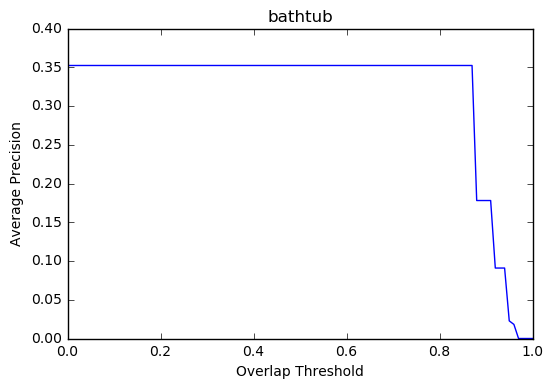

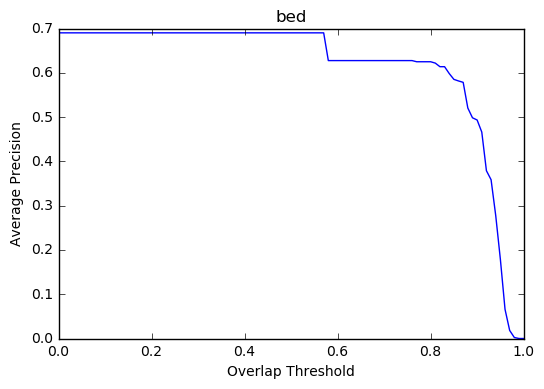

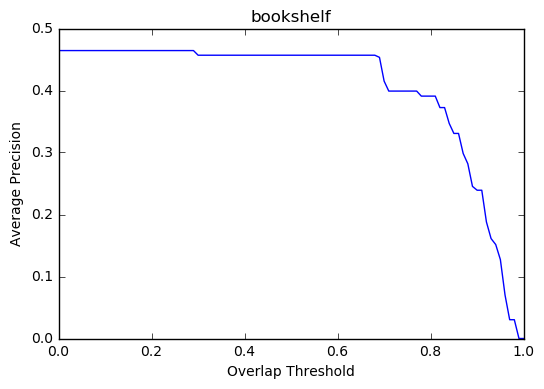

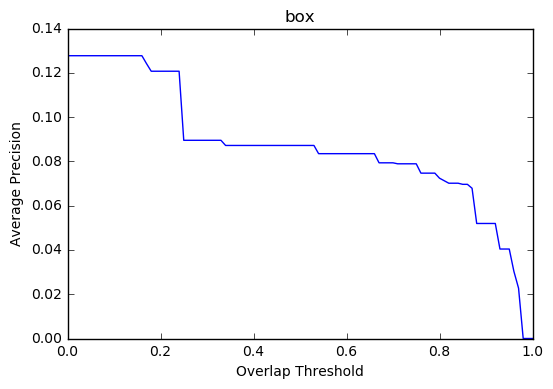

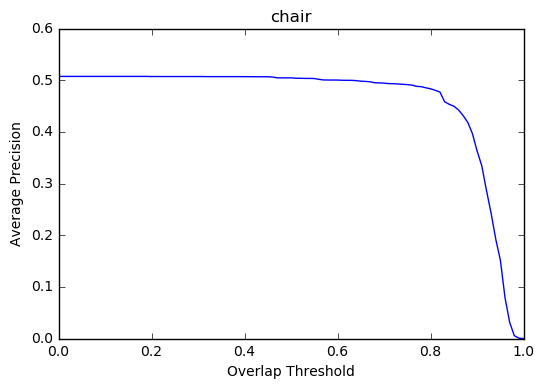

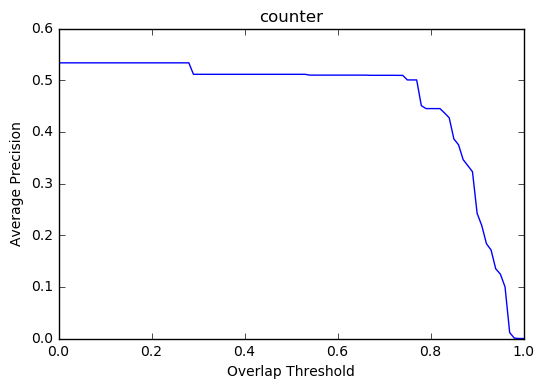

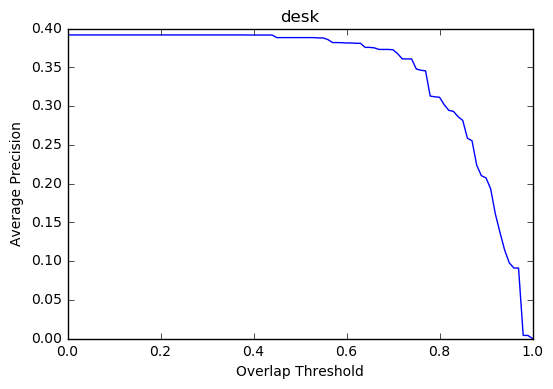

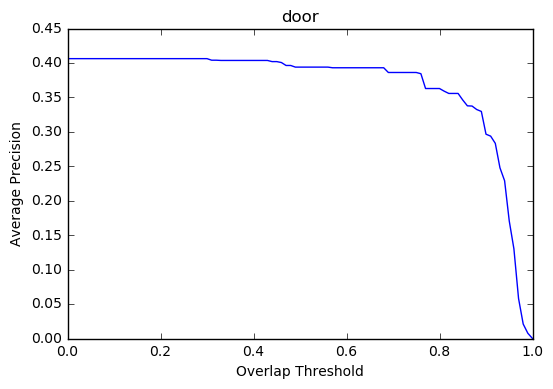

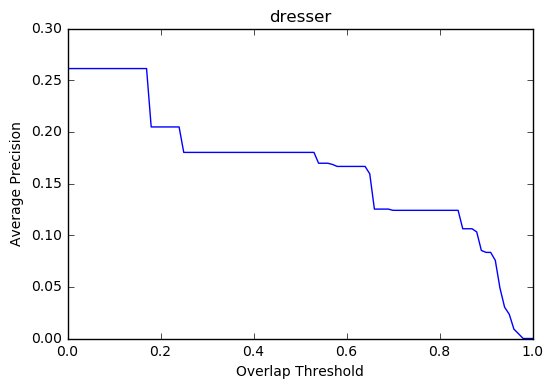

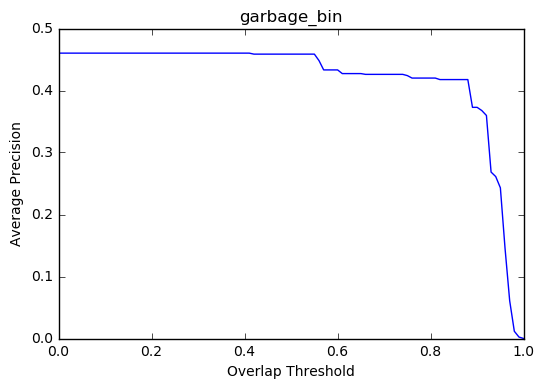

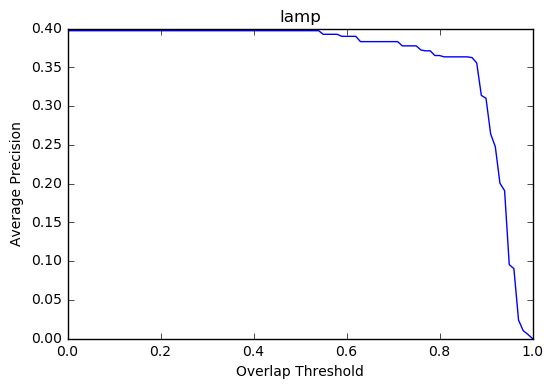

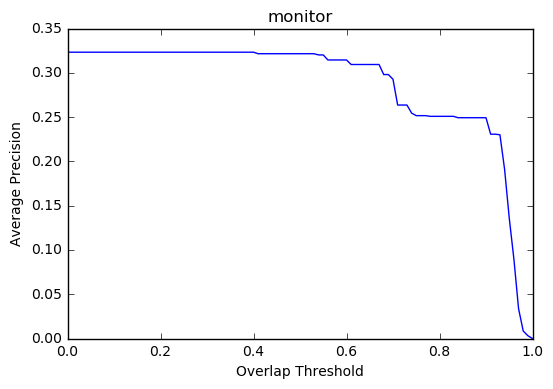

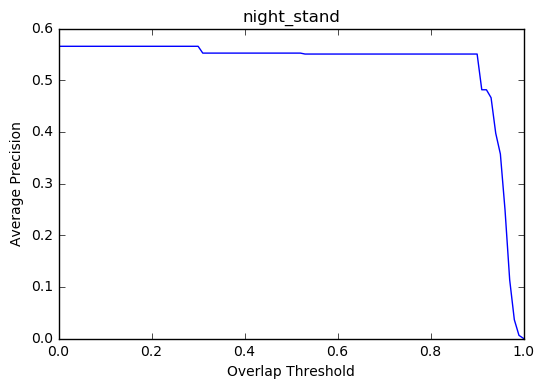

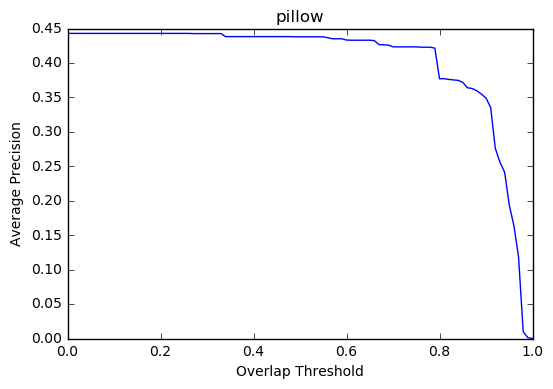

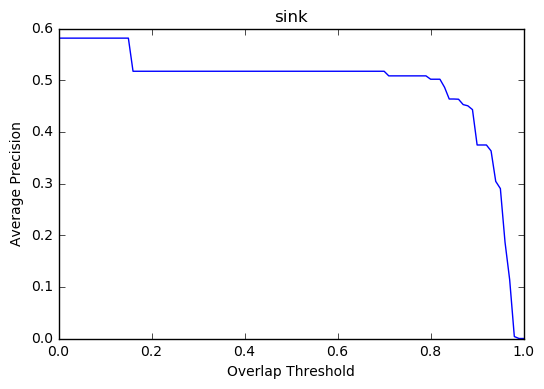

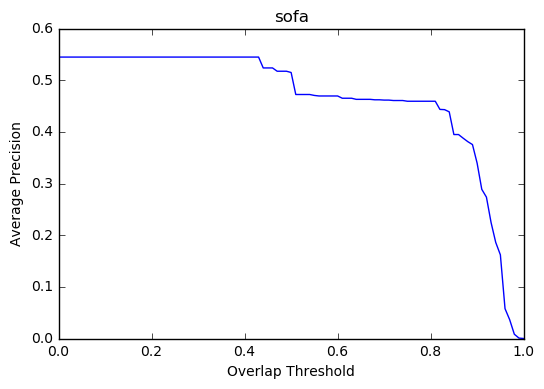

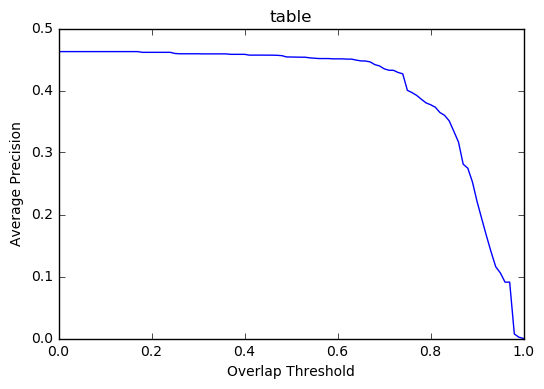

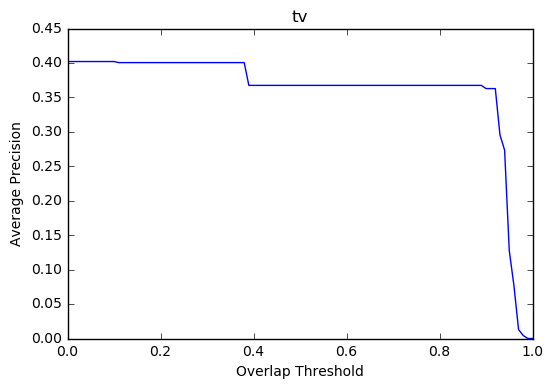

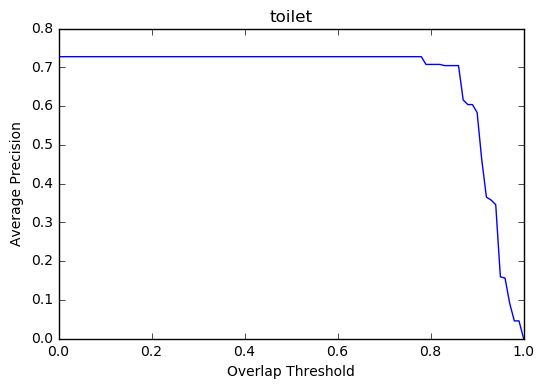

In [23]:

for k in range(len(NYU_CLASSES)):
    plt.figure()
    plt.plot(np.linspace(0, 1, 101), np.array(ap_array[k]))
    plt.title(NYU_CLASSES[k])
    plt.xlabel('Overlap Threshold')
    plt.ylabel('Average Precision')
    plt.savefig(('../results/ap_overlap/RGBD-1/'+NYU_CLASSES[k]+'.png'))

In [ ]:
for i, img in enumerate(images):
    plt.figure()
    if len(results[i]) == 0:
        continue
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.5]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    plt.imshow(img / 255.)
    currentAxis = plt.gca()


    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = NYU_CLASSES[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin, ymax-ymin
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.savefig('../results/detection_images/RGBD-1/image' + str(i) + '_v1.png')

In [ ]:
#calc_map()
y_true = []
for key in val_keys:
    y_true.append(gt[key])
y_true = np.array(y_true)
print(y_true.shape)

In [ ]:
inputs = []
images = []
for key in val_keys:
    img_path = path_prefix + key
    img = image.load_img(img_path, target_size=(300, 300))
    img = image.img_to_array(img)
    images.append(imread(img_path))
    inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

In [ ]:
#calc_map(y_true, results)
print(results[0])